## Welcome to the `Segformer Starter Block` Workshop!

In this workshop, we'll learn about building blocks of Segformer architecture.
1. **Overlap Patch Embedding**. A method to convert images to sequence of overlapping patches
2. **Efficient Self-Attention** - 1st Core component of all Transformer based models.
3. **Mix-FeedForward module** - 2nd core component of Transformer models. Along with Self-Attention, forms single Transformer block
4. **Transformer block** - Self-attention + Mix FFN + Layer Norm forms a basic Tranformer block

We'll cover these concepts in this notebook

In [1]:
# !pip install einops
# !pip install timm

In [2]:
# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# Segformer specific imports
from einops import rearrange

## 1. Overlap Patch Embedding


- Vision Transformers (ViT) pioneered the idea of Overlapping image patches.
- `ViT uses patches of size 16x16 along with positional encodings`. Hence the paper name (Image is worth 16x16 words)
- **In Segformer, authors propose smaller patch size (4x4) for semantic segmentation as its a dense prediction task**
- **No positional encoding for patches**

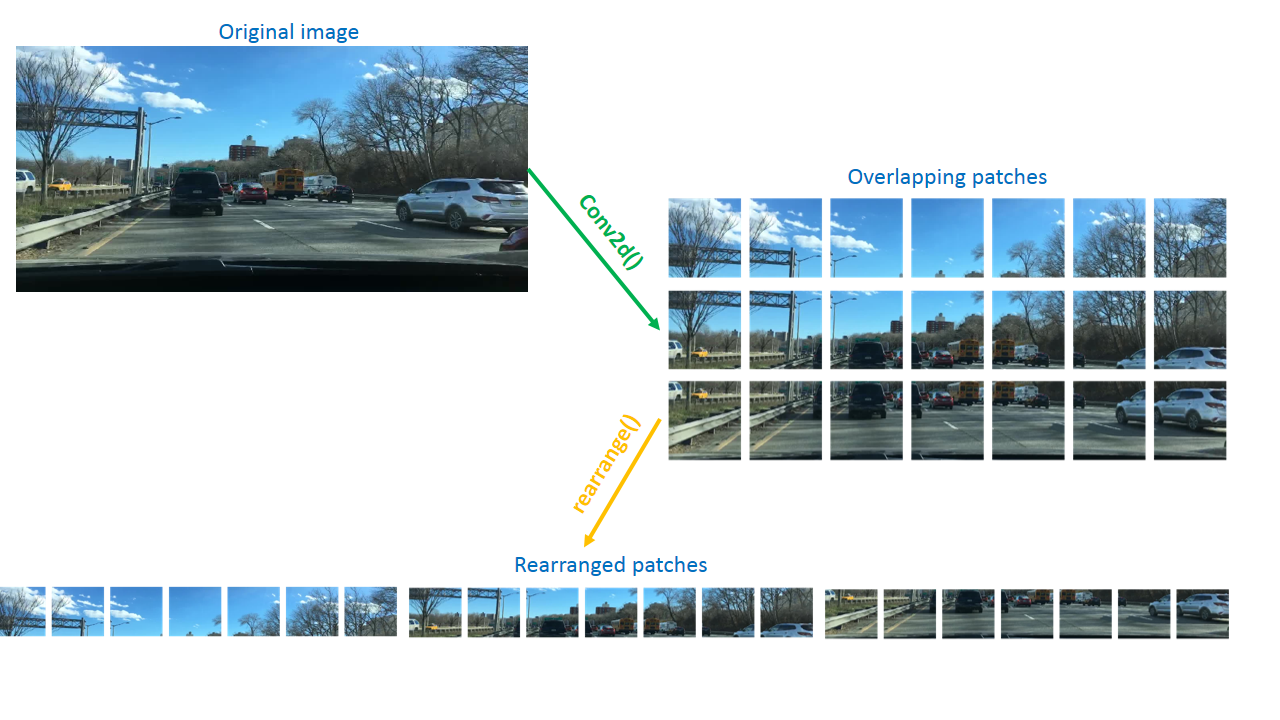

In [19]:
class overlap_patch_embed(nn.Module):
    """
    Overlap patch embedding: conv projection with overlap when stride < kernel_size.
    Input:  (B, C_in, H, W)
    Output: (B, N, embed_dim) where N = H'*W' (flattened patches)
    Also returns (H', W') for reshaping back to spatial maps.
    """
    def __init__(self, patch_size, stride, in_chans, embed_dim):
        super().__init__()

        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=patch_size,
                              stride=stride,
                              padding=patch_size // 2,
                              bias=True)
        self.norm = nn.LayerNorm(embed_dim)  # optional but helpful
        # init (follow common conv init)
        nn.init.kaiming_normal_(self.proj.weight, mode='fan_out', nonlinearity='relu')
        if self.proj.bias is not None:
            nn.init.zeros_(self.proj.bias)

    def forward(self, x):
        # x: (B, C_in, H, W)
        B, C, H, W = x.shape
        x = self.proj(x)               # (B, embed_dim, H', W')
        Hp, Wp = x.shape[2], x.shape[3]
        x = x.flatten(2).transpose(1, 2)  # (B, N=Hp*Wp, embed_dim)
        x = self.norm(x)               # normalize along feature dim
        return x, Hp, Wp


In [ ]:
# !wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/test_img.jpeg

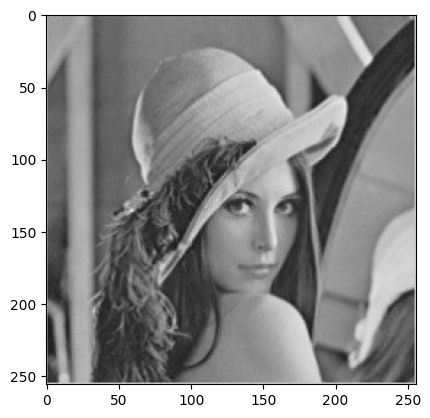

In [4]:
import matplotlib.pyplot as plt
import cv2

input_img = cv2.imread('test_img.jpeg')
plt.imshow(input_img)
plt.show()

In [5]:
input_img.shape

(256, 256, 3)

In [ ]:
from torchvision import transforms
convert_tensor = transforms.ToTensor()

overlap_patch_embed_input = convert_tensor(input_img).reshape(1, 3, 256, 256)
print("overlap_patch_embed_input.shape", overlap_patch_embed_input.shape)

overlap_patch_embed_input.shape torch.Size([1, 3, 256, 256])


In [11]:
model = overlap_patch_embed(patch_size=7, stride=4, in_chans=3, embed_dim=64)

In [ ]:
overlap_patch_embed_output, _, _ = model(overlap_patch_embed_input)
print("overlap_patch_embed_output.shape", overlap_patch_embed_output.shape)

overlap_patch_embed_output.shape torch.Size([1, 4096, 64])


### Patch × Feature activation matrix

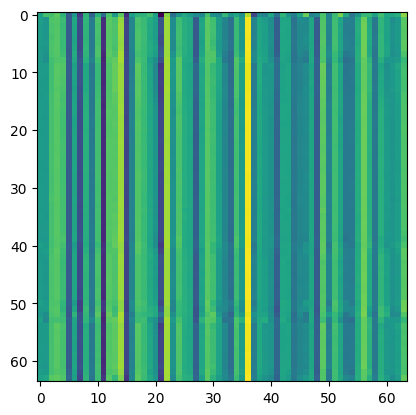

In [15]:
row = 0
col = 0
plt.imshow(overlap_patch_embed_output[0].detach().numpy()[row:row+64,col:col+64])
plt.show()

### Spatial Feature Map (per embedding channel)

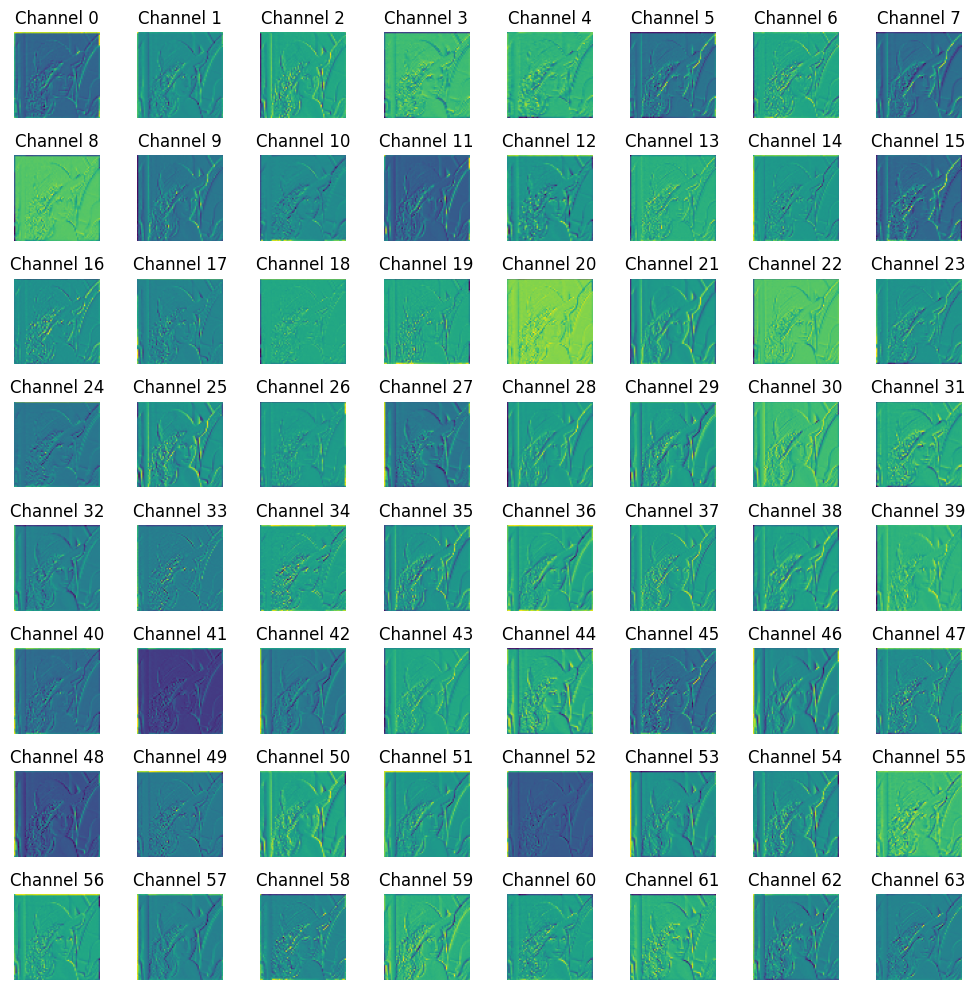

In [16]:
x = overlap_patch_embed_output[0]  # shape (4096, 64)
h = w = int(4096 ** 0.5)           # 64
x = x.reshape(h, w, 64)            # (64, 64, 64)

# show each channel as an image
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(x[:, :, i].detach().numpy(), cmap='viridis')
    ax.set_title(f'Channel {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()

Okay, because we have used a convolution with untrained weights, we might as well use a dummy input:

In [17]:
overlap_patch_embed_input = torch.Tensor(1, 3, 256, 256)

From which the process is the same:

In [18]:
model = overlap_patch_embed(patch_size= 7, stride =4, in_chans =3, embed_dim = 64)
overlap_patch_embed_output, _, _ = model(overlap_patch_embed_input)
print("overlap_patch_embed_input.shape", overlap_patch_embed_input.shape)
print("overlap_patch_embed_output.shape", overlap_patch_embed_output.shape)

ValueError: not enough values to unpack (expected 3, got 2)

## 2. Efficient Multi-head Self-Attention

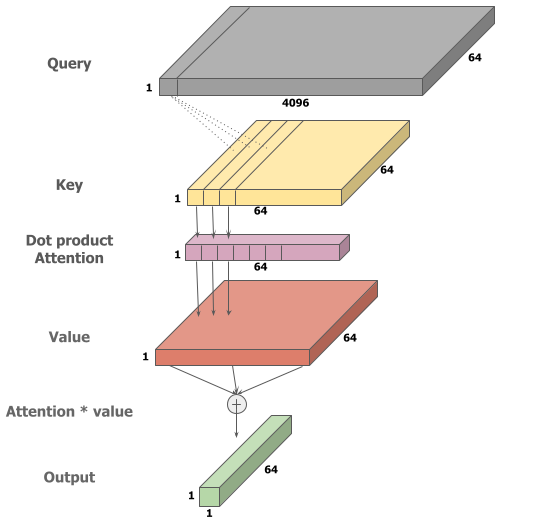

In [ ]:
class efficient_self_attention(nn.Module):
    def __init__(self, attn_dim, num_heads, dropout_p, sr_ratio):
        super().__init__()
        assert attn_dim % num_heads == 0, f'expected attn_dim {attn_dim} to be a multiple of num_heads {num_heads}'
        self.attn_dim = attn_dim
        self.num_heads = num_heads
        self.dropout_p = dropout_p
        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(attn_dim, attn_dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(attn_dim)

        # Multi-head Self-Attention using dot product
        # Query - Key Dot product is scaled by root of head_dim
        self.q = nn.Linear(attn_dim, attn_dim, bias=True)
        self.kv = nn.Linear(attn_dim, attn_dim * 2, bias=True)
        self.scale = (attn_dim // num_heads) ** -0.5

        # Projecting concatenated outputs from
        # multiple heads to single `attn_dim` size
        self.proj = nn.Linear(attn_dim, attn_dim)

    def forward(self, x, h, w):
        pass

In [ ]:
## Test with sample inputs
efficient_self_attention_input = torch.Tensor(1, 4096, 64)
model = efficient_self_attention(attn_dim= 64, num_heads = 1,
                                 dropout_p = 0, sr_ratio = 8)
efficient_self_attention_output = model(efficient_self_attention_input, h=64, w = 64)
print("efficient_self_attention_input.shape", efficient_self_attention_input.shape)
print("efficient_self_attention_output.shape", efficient_self_attention_output.shape)

## 3. Mix FeedForward Module

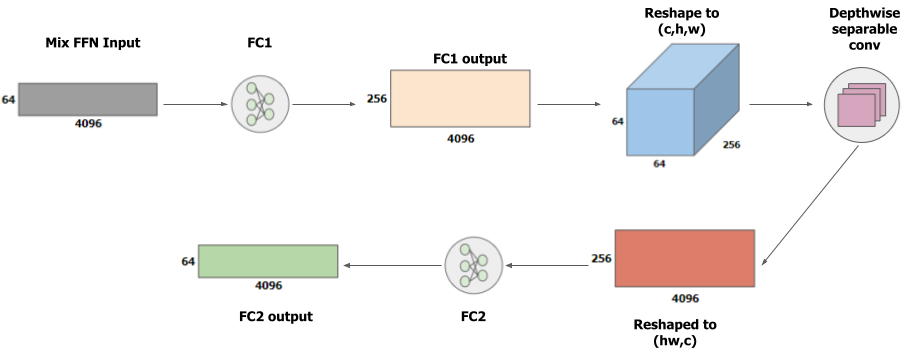

In [ ]:
class mix_feedforward(nn.Module):
    def __init__(self, in_features, out_features, hidden_features, dropout_p = 0.0):
        super().__init__()
        pass

    def forward(self, x, h, w):
        pass

In [ ]:
## Test with sample inputs
mix_feedforward_input = torch.Tensor(1, 4096, 64)
model = mix_feedforward(in_features=64, out_features=64, hidden_features=256)
mix_feedforward_output = model(mix_feedforward_input, h=64, w = 64)
print("mix_feedforward_input.shape", mix_feedforward_input.shape)
print("mix_feedforward_output.shape", mix_feedforward_output.shape)

## 4. Transformer Block

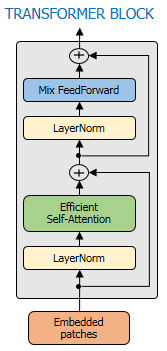

In [ ]:
class transformer_block(nn.Module):
    def __init__(self, dim, num_heads, dropout_p, sr_ratio):
        super().__init__()
        # One transformer block is defined as :
        # Norm -> self-attention -> Norm -> FeedForward
        # skip-connections are added after attention and FF layers
        self.attn = efficient_self_attention(attn_dim=dim, num_heads=num_heads,
                    dropout_p=dropout_p, sr_ratio=sr_ratio)
        self.ffn = mix_feedforward( dim, dim, hidden_features=dim * 4, dropout_p=dropout_p)
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)


    def forward(self, x, h, w):
        pass

In [ ]:
## Test with sample inputs
transformer_block_input = torch.Tensor(1, 4096, 64)
model = transformer_block(dim=64, num_heads=1, dropout_p=0.1, sr_ratio=8)
transformer_block_output = model(transformer_block_input, h=64, w = 64)
print("transformer_block_input.shape", transformer_block_input.shape)
print("transformer_block_output.shape", transformer_block_output.shape)